## Impact of Several Factors on Crop Yield in India (1997-2020)

Monash Data Analytics Bootcamp - Project 1

Done by Group 3 (Nicholas, Rajendra, Duc)

Objective: To determine factors that impacted Indian crop yield from 1997 to 2020 using datasets/APIs available in the Internet for free.

**Preparation**

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import hvplot.pandas
import requests
import pandas as pd
import scipy.stats as st
import numpy as np
import warnings
from pathlib import Path
from scipy.stats import linregress
from scipy.stats import ttest_ind

# Importing API keys
from config import api_key
from api_keys import weather_api_key

**Data Synthesis and Cleanup**

In [2]:
# Creating file paths for each .csv file
crop_csv = Path("resources/crop_yield.csv")

# Creating DataFrames from each .csv file
crop = pd.read_csv(crop_csv)

# Removing any results from both DataFrames that contain null values
crop.dropna(how='any')

# Previewing crop Dataframe
crop.head()

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


# Nicholas

# Temperature vs. Crop Yield

In [3]:
# Creating file path for temp .csv file
temp_csv = Path("resources/TEMP_ANNUAL_SEASONAL_MEAN.csv")

# Creating temp DataFrame
temp = pd.read_csv(temp_csv)

# cleaining temp Dataframe
temp.dropna(how='any')

,YEAR,ANNUAL,JAN-FEB,MAR-MAY,JUN-SEP,OCT-DEC
0,1901.0,25.42,20.11,27.64,28.16,23.1
1,1902.0,25.42,20.88,27.96,27.98,22.51
2,1903.0,25.01,19.99,27.02,28,22.33
3,1904.0,24.93,19.76,27.23,27.57,22.56
4,1905.0,24.84,18.36,26.38,28.2,23.13
...,...,...,...,...,...,...
116,2017.0,26.04,21.37,28.2,28.39,23.84
117,2018.0,25.9,21.24,28.16,28.28,23.55
118,2019.0,25.86,20.71,28,28.6,23.49
119,2020.0,25.78,20.79,27.58,28.45,23.75


In [4]:
# Picking out relevant columns
crop_cleaned = crop[['Crop', 'Crop_Year', 'Area', 'Production', 'Yield']]
crop_cleaned = crop_cleaned.rename({'Crop_Year': 'Year'}, axis='columns')
crop_cleaned.head()

,Crop,Year,Area,Production,Yield
0,Arecanut,1997,73814.0,56708,0.796087
1,Arhar/Tur,1997,6637.0,4685,0.710435
2,Castor seed,1997,796.0,22,0.238333
3,Coconut,1997,19656.0,126905000,5238.051739
4,Cotton(lint),1997,1739.0,794,0.420909


In [5]:
# The plan now is to create multiple DataFrames based on the 5 most produced crops.
# This analysis will thus only focus on rice, maize, moong, ruad and groundnut crops.
crop_cleaned['Crop'].value_counts()

Crop
Rice                     1197
Maize                     975
Moong(Green Gram)         740
Urad                      733
Groundnut                 725
Sesamum                   685
Potato                    628
Sugarcane                 605
Wheat                     545
Rapeseed &Mustard         528
Bajra                     524
Jowar                     513
Arhar/Tur                 508
Ragi                      498
Gram                      490
Small millets             485
Cotton(lint)              476
Onion                     454
Sunflower                 441
Dry chillies              419
Other Kharif pulses       382
Horse-gram                371
Peas & beans (Pulses)     369
Tobacco                   364
Other  Rabi pulses        355
Soyabean                  349
Turmeric                  337
Masoor                    324
Ginger                    323
Linseed                   308
Castor seed               300
Barley                    297
Sweet potato              273
Garli

In [6]:
# creating DataFrames grouped by crop
warnings.filterwarnings('ignore')

rice = crop_cleaned[crop_cleaned['Crop'] == 'Rice']
maize = crop_cleaned[crop_cleaned['Crop'] == 'Maize']
moong = crop_cleaned[crop_cleaned['Crop'] == 'Moong(Green Gram)']
urad = crop_cleaned[crop_cleaned['Crop'] == 'Urad']
groundnut = crop_cleaned[crop_cleaned['Crop'] == 'Groundnut']

rice = rice.groupby(['Year']).sum().reset_index()
maize = maize.groupby(['Year']).sum().reset_index()
moong = moong.groupby(['Year']).sum().reset_index()
urad = urad.groupby(['Year']).sum().reset_index()
groundnut = groundnut.groupby(['Year']).sum().reset_index()

In [7]:
# Only taking annual temperature
temp_a = temp[['YEAR', 'ANNUAL']]

# Converting temp['YEAR'] into int to match crop_cleaned['Year']
temp_a = temp_a.fillna(value=0)
temp_a['YEAR'] = temp_a['YEAR'].astype(int)

# Renaming temp_a columns
temp_a = temp_a.rename({'YEAR': 'Year','ANNUAL': 'Annual Temp'}, axis='columns')

# Previewing temp DataFrame to see if change has occured
temp_a.head()

,Year,Annual Temp
0,1901,25.42
1,1902,25.42
2,1903,25.01
3,1904,24.93
4,1905,24.84


In [8]:
# Merging created crop DataFrames with temp DataFrame
rice_temp = rice.merge(temp_a, on='Year')
maize_temp = maize.merge(temp_a, on='Year')
moong_temp = moong.merge(temp_a, on='Year')
urad_temp = urad.merge(temp_a, on='Year')
groundnut_temp = groundnut.merge(temp_a, on='Year')

In [9]:
# Creating .csv files of each DataFrame for viewing
rice_temp.to_csv("output/rice_temp.csv")
maize_temp.to_csv("output/maize_temp.csv")
moong_temp.to_csv("output/moong_temp.csv")
urad_temp.to_csv("output/urad_temp.csv")
groundnut_temp.to_csv("output/groundnut_temp.csv")

**Data Visualisation and Analysis**

Any p-value equal or below 0.05 indicates that the correlation is statistically significant.

In [10]:
# We want to sort our DataFrames in regards to annual temperature in preparation for scatter plot making
rice_temp = rice_temp.sort_values(by='Annual Temp', ascending=True)
maize_temp = maize_temp.sort_values(by='Annual Temp', ascending=True)
moong_temp = moong_temp.sort_values(by='Annual Temp', ascending=True)
urad_temp = urad_temp.sort_values(by='Annual Temp', ascending=True)
groundnut_temp = groundnut_temp.sort_values(by='Annual Temp', ascending=True)

In [11]:
# Define a function to create Linear Regression plots
def lin_reg(x, y):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    r_sq = rvalue ** 2
    
    return regress_values, line_eq, rvalue, pvalue

The r-value is: 0.45710506967015396
The p-value is: 0.024725862984342137


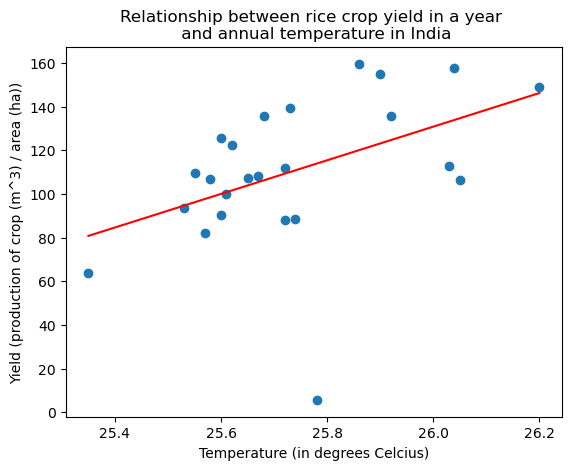

In [12]:
# Rice vs. Temperature visualisation
rice_temp['Annual Temp'] = rice_temp['Annual Temp'].astype('float')
rice_temp['Yield'] = rice_temp['Yield'].astype('float')
regress_values, line_eq, rvalue, pvalue = lin_reg(rice_temp['Annual Temp'], rice_temp['Yield'])
plt.scatter(rice_temp['Annual Temp'], rice_temp['Yield'])
plt.plot(rice_temp['Annual Temp'], regress_values, "r-")
plt.title("Relationship between rice crop yield in a year \n and annual temperature in India")
plt.xlabel("Temperature (in degrees Celcius)")
plt.ylabel("Yield (production of crop (m^3) / area (ha))")
print(f"The r-value is: {rvalue}")
print(f"The p-value is: {pvalue}")
plt.savefig("output/rice_yield_temp.png")
plt.show()

There is a moderate and positive relationship between rice crop yield and temperature which is statistically significant, suggesting that the rice crop yield for the year may tend to increase as the annual temperature increases.

The r-value is: -0.31530688229639653
The p-value is: 0.13340503860004996


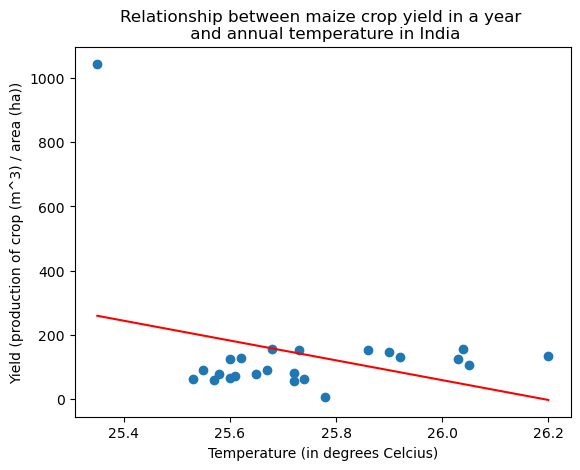

In [13]:
# Maize vs. Temperature visualisation
maize_temp['Annual Temp'] = maize_temp['Annual Temp'].astype('float')
maize_temp['Yield'] = maize_temp['Yield'].astype('float')
regress_values, line_eq, rvalue, pvalue = lin_reg(maize_temp['Annual Temp'], maize_temp['Yield'])
plt.scatter(maize_temp['Annual Temp'], maize_temp['Yield'])
plt.plot(maize_temp['Annual Temp'], regress_values, "r-")
plt.title("Relationship between maize crop yield in a year \n and annual temperature in India")
plt.xlabel("Temperature (in degrees Celcius)")
plt.ylabel("Yield (production of crop (m^3) / area (ha))")
print(f"The r-value is: {rvalue}")
print(f"The p-value is: {pvalue}")
plt.savefig("output/maize_yield_temp.png")
plt.show()

There is no statistically significant relationship between maize crop yield and temperature.

It should be noted that there is an outlier where a relatively low temperature is associated with an enormous yield which may have impacted the linear regression.

The r-value is: 0.6020658834832703
The p-value is: 0.0018529520291190693


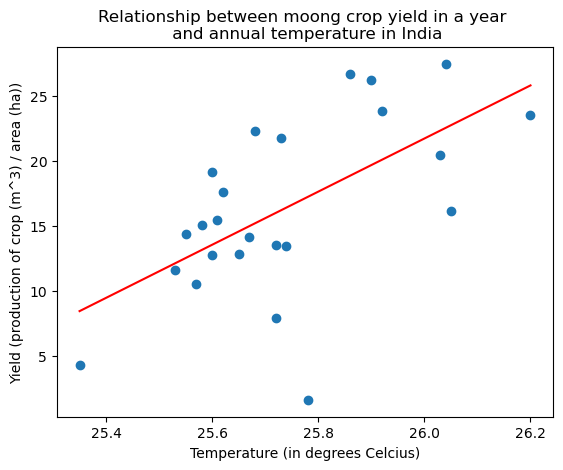

In [14]:
# Moong vs. Temperature visualisation
moong_temp['Annual Temp'] = moong_temp['Annual Temp'].astype('float')
moong_temp['Yield'] = moong_temp['Yield'].astype('float')
regress_values, line_eq, rvalue, pvalue = lin_reg(moong_temp['Annual Temp'], moong_temp['Yield'])
plt.scatter(moong_temp['Annual Temp'], moong_temp['Yield'])
plt.plot(moong_temp['Annual Temp'], regress_values, "r-")
plt.title("Relationship between moong crop yield in a year \n and annual temperature in India")
plt.xlabel("Temperature (in degrees Celcius)")
plt.ylabel("Yield (production of crop (m^3) / area (ha))")
print(f"The r-value is: {rvalue}")
print(f"The p-value is: {pvalue}")
plt.savefig("output/moong_yield_temp.png")
plt.show()

There is a high and positive relationship between moong crop yield and temperature which is statistically significant, suggesting that the moong crop yield for the year is likely to increase as the annual temperature increases.

The r-value is: 0.5728777049416954
The p-value is: 0.003434202796522955


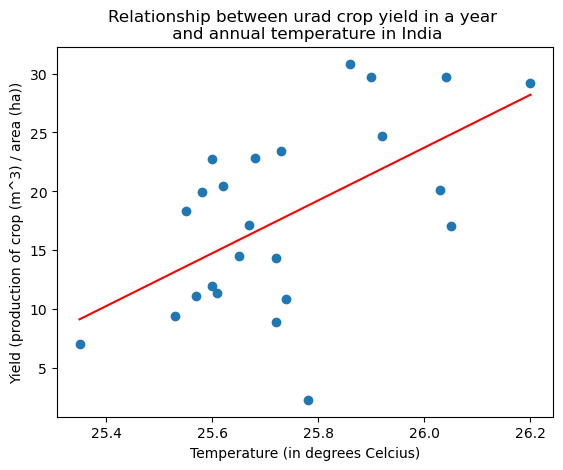

In [15]:
# Urad vs. Temperature visualisation
urad_temp['Annual Temp'] = urad_temp['Annual Temp'].astype('float')
urad_temp['Yield'] = urad_temp['Yield'].astype('float')
regress_values, line_eq, rvalue, pvalue = lin_reg(urad_temp['Annual Temp'], urad_temp['Yield'])
plt.scatter(urad_temp['Annual Temp'], urad_temp['Yield'])
plt.plot(urad_temp['Annual Temp'], regress_values, "r-")
plt.title("Relationship between urad crop yield in a year \n and annual temperature in India")
plt.xlabel("Temperature (in degrees Celcius)")
plt.ylabel("Yield (production of crop (m^3) / area (ha))")
print(f"The r-value is: {rvalue}")
print(f"The p-value is: {pvalue}")
plt.savefig("output/urad_yield_temp.png")
plt.show()

There is a moderate and positive relationship between urad crop yield and temperature which is statistically significant, suggesting that the urad crop yield for the year may tend to increase as the annual temperature increases.

The r-value is: 0.5419621453333502
The p-value is: 0.006226278557397902


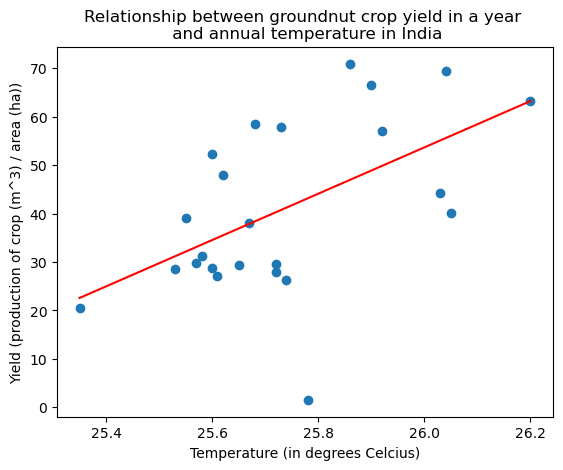

In [16]:
# Groundnut vs. Temperature visualisation
groundnut_temp['Annual Temp'] = groundnut_temp['Annual Temp'].astype('float')
groundnut_temp['Yield'] = groundnut_temp['Yield'].astype('float')
regress_values, line_eq, rvalue, pvalue = lin_reg(groundnut_temp['Annual Temp'], groundnut_temp['Yield'])
plt.scatter(groundnut_temp['Annual Temp'], groundnut_temp['Yield'])
plt.plot(groundnut_temp['Annual Temp'], regress_values, "r-")
plt.title("Relationship between groundnut crop yield in a year \n and annual temperature in India")
plt.xlabel("Temperature (in degrees Celcius)")
plt.ylabel("Yield (production of crop (m^3) / area (ha))")
print(f"The r-value is: {rvalue}")
print(f"The p-value is: {pvalue}")
plt.savefig("output/groundnut_yield_temp.png")
plt.show()

There is a moderate and positive relationship between groundnut crop yield and temperature which is statistically significant, suggesting that the groundnut crop yield for the year may tend to increase as the annual temperature increases.

Data from 2020 should be consider as outliers due to the extremely low yield when compared to other years. This may be related to the 2020-2021 Indian farmer protest and the nation-wide shutdown of agriculture as a form of protest.

# Rainfall vs. Crop Yield

In [17]:
# Picking out relevant columns
crop_cleaned = crop[['Crop', 'Crop_Year', 'State', 'Annual_Rainfall', 'Yield']]

# Displaying created DataFrame
crop_cleaned.head()

,Crop,Crop_Year,State,Annual_Rainfall,Yield
0,Arecanut,1997,Assam,2051.4,0.796087
1,Arhar/Tur,1997,Assam,2051.4,0.710435
2,Castor seed,1997,Assam,2051.4,0.238333
3,Coconut,1997,Assam,2051.4,5238.051739
4,Cotton(lint),1997,Assam,2051.4,0.420909


In [18]:
# As determined in temperature_analysis.ipynb, the top 5 crops are: rice, maize, moong, urad and groundnut
# Unlike temperature, annual rainfall is provided for each state each year.
warnings.filterwarnings('ignore')

# Creating new DataFrames grouped by crop
rice = crop_cleaned[crop_cleaned['Crop'] == 'Rice']
maize = crop_cleaned[crop_cleaned['Crop'] == 'Maize']
moong = crop_cleaned[crop_cleaned['Crop'] == 'Moong(Green Gram)']
urad = crop_cleaned[crop_cleaned['Crop'] == 'Urad']
groundnut = crop_cleaned[crop_cleaned['Crop'] == 'Groundnut']

# Sorting by state and year for beautification purposes (they do not have any impact in this analysis).
# Unlike the temperature analysis, rainfall provided is for each state each year, therefore no
# generalisation is done in this analysis.
rice = rice.groupby(['State', 'Crop_Year']).sum().reset_index()
maize = maize.groupby(['State', 'Crop_Year']).sum().reset_index()
moong = moong.groupby(['State', 'Crop_Year']).sum().reset_index()
urad = urad.groupby(['State', 'Crop_Year']).sum().reset_index()
groundnut = groundnut.groupby(['State', 'Crop_Year']).sum().reset_index()

In [19]:
# Creating .csv files of each DataFrame for viewing
rice.to_csv("output/rice_rainfall.csv")
maize.to_csv("output/maize_rainfall.csv")
moong.to_csv("output/moong_rainfall.csv")
urad.to_csv("output/urad_rainfall.csv")
groundnut.to_csv("output/groundnut_rainfall.csv")

**Data Visualisation and Analysis**

Any p-value equal or below 0.05 indicates that the correlation is statistically significant.

The r-value is: 0.5342361278391471
The p-value is: 2.559085635606649e-49


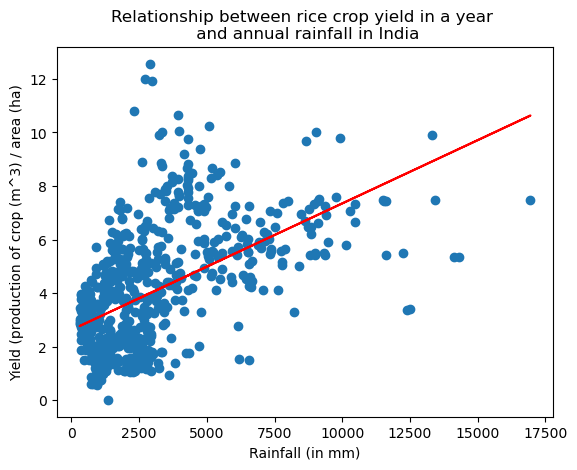

In [20]:
# Rice vs. Rainfall visualisation
rice['Annual_Rainfall'] = rice['Annual_Rainfall'].astype('float')
rice['Yield'] = rice['Yield'].astype('float')
regress_values, line_eq, rvalue, pvalue = lin_reg(rice['Annual_Rainfall'], rice['Yield'])
plt.scatter(rice['Annual_Rainfall'], rice['Yield'])
plt.plot(rice['Annual_Rainfall'], regress_values, "r-")
plt.title("Relationship between rice crop yield in a year \n and annual rainfall in India")
plt.xlabel("Rainfall (in mm)")
plt.ylabel("Yield (production of crop (m^3) / area (ha)")
print(f"The r-value is: {rvalue}")
print(f"The p-value is: {pvalue}")
plt.savefig("output/rice_yield_rainfall.png")
plt.show()

There is a strong and positive relationship between rice crop yield and rainfall which is statistically significant, suggesting that the rice crop yield is likely to increase as amount of rainfall increases.

The r-value is: 0.08584566839245644
The p-value is: 0.03678370370221179


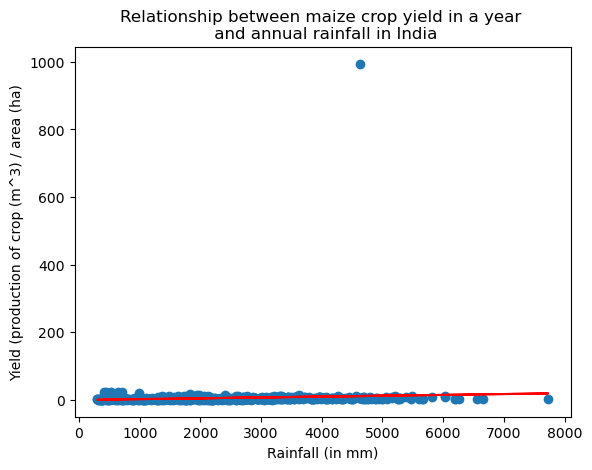

In [21]:
# Maize vs. Rainfall visualisation
maize['Annual_Rainfall'] = maize['Annual_Rainfall'].astype('float')
maize['Yield'] = maize['Yield'].astype('float')
regress_values, line_eq, rvalue, pvalue = lin_reg(maize['Annual_Rainfall'], maize['Yield'])
plt.scatter(maize['Annual_Rainfall'], maize['Yield'])
plt.plot(maize['Annual_Rainfall'], regress_values, "r-")
plt.title("Relationship between maize crop yield in a year \n and annual rainfall in India")
plt.xlabel("Rainfall (in mm)")
plt.ylabel("Yield (production of crop (m^3) / area (ha)")
print(f"The r-value is: {rvalue}")
print(f"The p-value is: {pvalue}")
plt.savefig("output/maize_yield_rainfall.png")
plt.show()

While the relationship between maize crop yield and rainfall is statistically significant, it is also very weak.

Considering that the scatter plot for the relationship between maize crop yield and temperature is similar to this scatter plot, it is safe to say that maize probably works differently to other crops in that both temperature and rainfall do not impact on its growth.

The r-value is: 0.5585930727211041
The p-value is: 2.773084378400102e-38


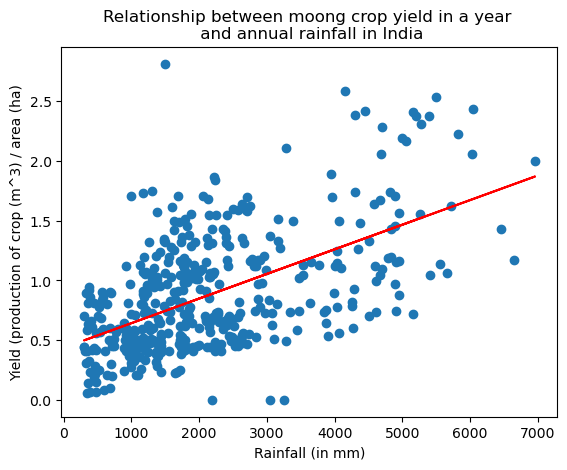

In [22]:
# Moong vs. Rainfall visualisation
moong['Annual_Rainfall'] = moong['Annual_Rainfall'].astype('float')
moong['Yield'] = moong['Yield'].astype('float')
regress_values, line_eq, rvalue, pvalue = lin_reg(moong['Annual_Rainfall'], moong['Yield'])
plt.scatter(moong['Annual_Rainfall'], moong['Yield'])
plt.plot(moong['Annual_Rainfall'], regress_values, "r-")
plt.title("Relationship between moong crop yield in a year \n and annual rainfall in India")
plt.xlabel("Rainfall (in mm)")
plt.ylabel("Yield (production of crop (m^3) / area (ha)")
print(f"The r-value is: {rvalue}")
print(f"The p-value is: {pvalue}")
plt.savefig("output/moong_yield_rainfall.png")
plt.show()

There is a moderate and positive relationship between moong crop yield and rainfall which is statistically significant, suggesting that the moong crop yield may tend to increase as amount of rainfall increases.

The r-value is: 0.5067055069489329
The p-value is: 9.210244872720177e-32


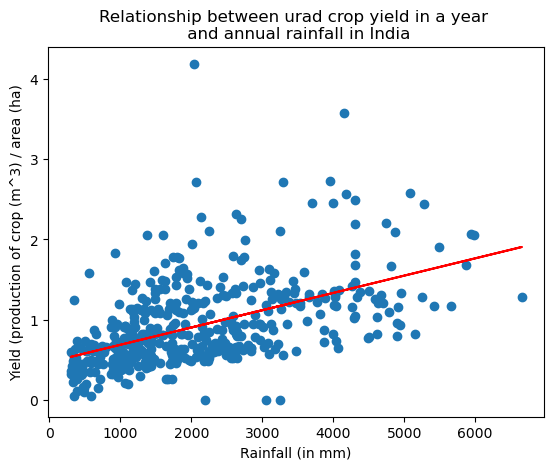

In [23]:
# Urad vs. Rainfall visualisation
urad['Annual_Rainfall'] = urad['Annual_Rainfall'].astype('float')
urad['Yield'] = urad['Yield'].astype('float')
regress_values, line_eq, rvalue, pvalue = lin_reg(urad['Annual_Rainfall'], urad['Yield'])
plt.scatter(urad['Annual_Rainfall'], urad['Yield'])
plt.plot(urad['Annual_Rainfall'], regress_values, "r-")
plt.title("Relationship between urad crop yield in a year \n and annual rainfall in India")
plt.xlabel("Rainfall (in mm)")
plt.ylabel("Yield (production of crop (m^3) / area (ha)")
print(f"The r-value is: {rvalue}")
print(f"The p-value is: {pvalue}")
plt.savefig("output/urad_yield_rainfall.png")
plt.show()

There is a moderate and positive relationship between urad crop yield and rainfall which is statistically significant, suggesting that the urad crop yield nay tend to increase as amount of rainfall increases.

The r-value is: 0.6210760232727784
The p-value is: 6.638009287263685e-52


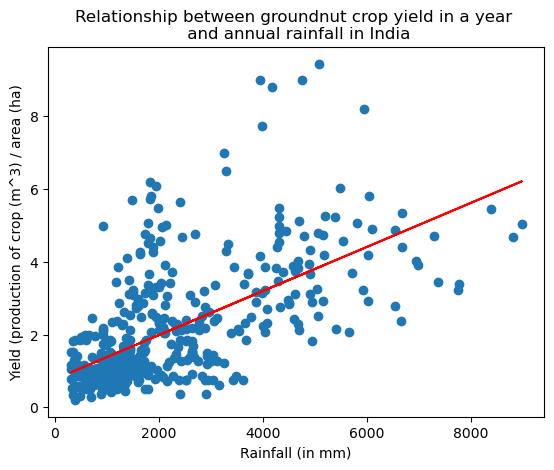

In [24]:
# Groundnut vs. Rainfall visualisation
groundnut['Annual_Rainfall'] = groundnut['Annual_Rainfall'].astype('float')
groundnut['Yield'] = groundnut['Yield'].astype('float')
regress_values, line_eq, rvalue, pvalue = lin_reg(groundnut['Annual_Rainfall'], groundnut['Yield'])
plt.scatter(groundnut['Annual_Rainfall'], groundnut['Yield'])
plt.plot(groundnut['Annual_Rainfall'], regress_values, "r-")
plt.title("Relationship between groundnut crop yield in a year \n and annual rainfall in India")
plt.xlabel("Rainfall (in mm)")
plt.ylabel("Yield (production of crop (m^3) / area (ha)")
print(f"The r-value is: {rvalue}")
print(f"The p-value is: {pvalue}")
plt.savefig("output/groundnut_yield_rainfall.png")
plt.show()

There is a strong and positive relationship between groundnut crop yield and rainfall which is statistically significant, suggesting that the groundnut crop yield is likely to increase as amount of rainfall increases.

## Rajendra

## One-way ANOVA Hypothesis Testing of Total Crop Production for Each Season in India

In [25]:
# Study data files
crop_yield_data_path = "resources/crop_yield.csv"

# Read the mouse data and the study results
crop_yield_df = pd.read_csv(crop_yield_data_path)

# Display the data table for preview
crop_yield_df.head()

# Checking the null values
crop_yield_df[crop_yield_df.isnull().any(axis=1)]

# Drop rows if there are any null values
crop_yield_df.dropna(axis=0, how="all")

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909
...,...,...,...,...,...,...,...,...,...,...
19684,Small millets,1998,Kharif,Nagaland,4000.0,2000,1498.0,395200.00,1160.00,0.500000
19685,Wheat,1998,Rabi,Nagaland,1000.0,3000,1498.0,98800.00,290.00,3.000000
19686,Maize,1997,Kharif,Jammu and Kashmir,310883.0,440900,1356.2,29586735.11,96373.73,1.285000
19687,Rice,1997,Kharif,Jammu and Kashmir,275746.0,5488,1356.2,26242746.82,85481.26,0.016667


<Axes: title={'center': 'Production'}, xlabel='Season'>

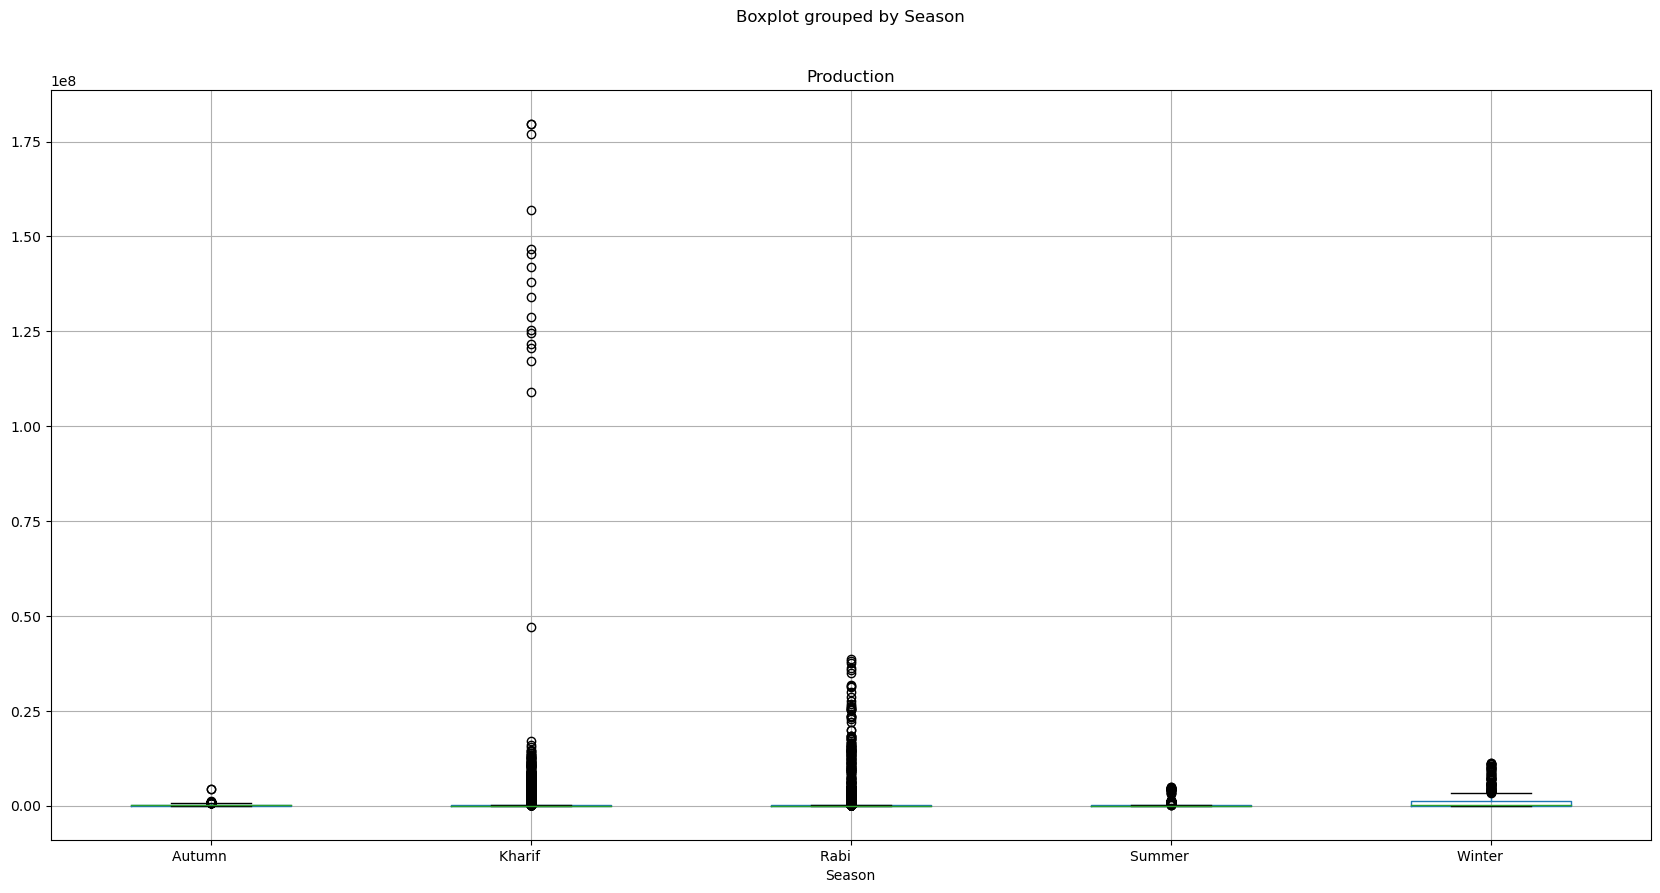

In [26]:
# Extract seasons
season_group_df = crop_yield_df[crop_yield_df["Season"].str.strip()!="Whole Year"]
seasons = season_group_df["Season"].unique()

# Create a boxplot to compare means
season_group_df.boxplot("Production", by="Season", figsize=(20, 10))

In [27]:
#Extract individual groups
group0 = season_group_df[season_group_df["Season"] == seasons[0]]['Production']
group1 = season_group_df[season_group_df["Season"] == seasons[1]]['Production']
group2 = season_group_df[season_group_df["Season"] == seasons[2]]['Production']
group3 = season_group_df[season_group_df["Season"] == seasons[3]]['Production']
group4 = season_group_df[season_group_df["Season"] == seasons[4]]['Production']


#Perform the ANOVA
st.f_oneway(group0, group1, group2, group3, group4) 
print("\x1b[36;1mANOVA suggests to accept Alternate hypothesis as pvalue > 0.05,\nwhich implies seasons has significant impact on Crop Production or Yield\x1b[0m")

ANOVA suggests to accept Alternate hypothesis as pvalue > 0.05,
which implies seasons has significant impact on Crop Production or Yield


## Seasons vs. Crop Yield

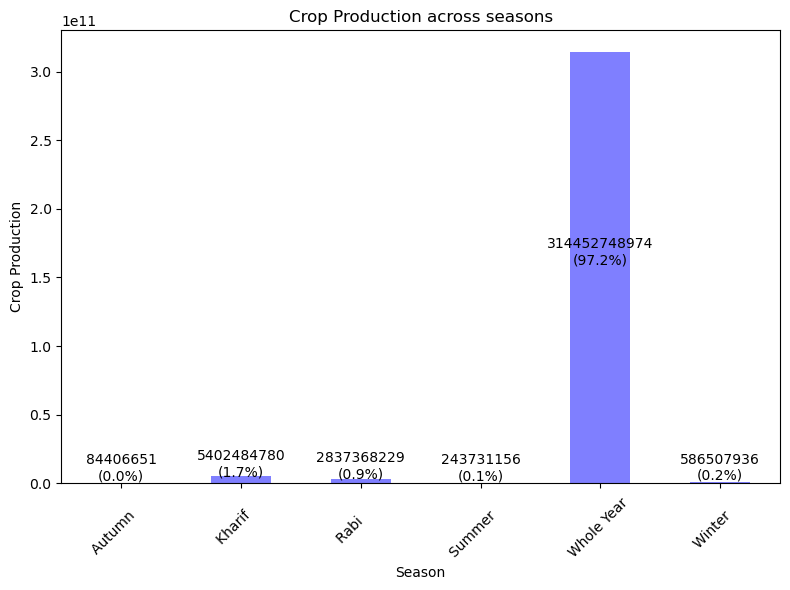

Highest Crop season : Kharif with the Crop Production : 5402484780 
Lowest Crop season : Autumn with the Crop Production : 84406651


In [28]:
# Generate a bar plot showing the crop production for each season using Pandas.
crop_season_df = crop_yield_df.groupby(['Season'])['Production'].sum()
crop_season_df.sort_values(ascending=False)

#Highest and lowest crop production across the seasons
seasons_df = crop_season_df[crop_season_df.keys().str.strip()!="Whole Year"]
max_value = seasons_df.max()
min_value = seasons_df.min()
heighest_season = seasons_df[seasons_df.values==max_value].keys()
lowest_season  = seasons_df[seasons_df.values==min_value].keys()

# create a bar plot
bar_plot = crop_season_df.plot(kind="bar", figsize=(8,6),title="Crop Production across seasons",color='b', alpha=0.5, align="center")
plt.xticks(rotation=45)
plt.ylabel("Crop Production")

# Annotate the bar values
for bar in bar_plot.patches:
    # get the height, width, and position of each bar
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    
    # format the label with the value and percentage
    label_text = f"{height}\n({height/sum(crop_yield_df['Production']):.1%})"
  
    # add the label to the bar
    bar_plot.annotate(label_text, xy=(x + width/2, y + height/2),
                      ha="center", va="bottom")
    
plt.tight_layout()
plt.savefig("output/seasons_crop_yield.png")
plt.show()

print(f"Highest Crop season : {heighest_season[0].strip()} with the Crop Production : {max_value} \nLowest Crop season : {lowest_season[0].strip()} with the Crop Production : {min_value}")

## Best Crop Based on Crop Yield from 1997 to 2020

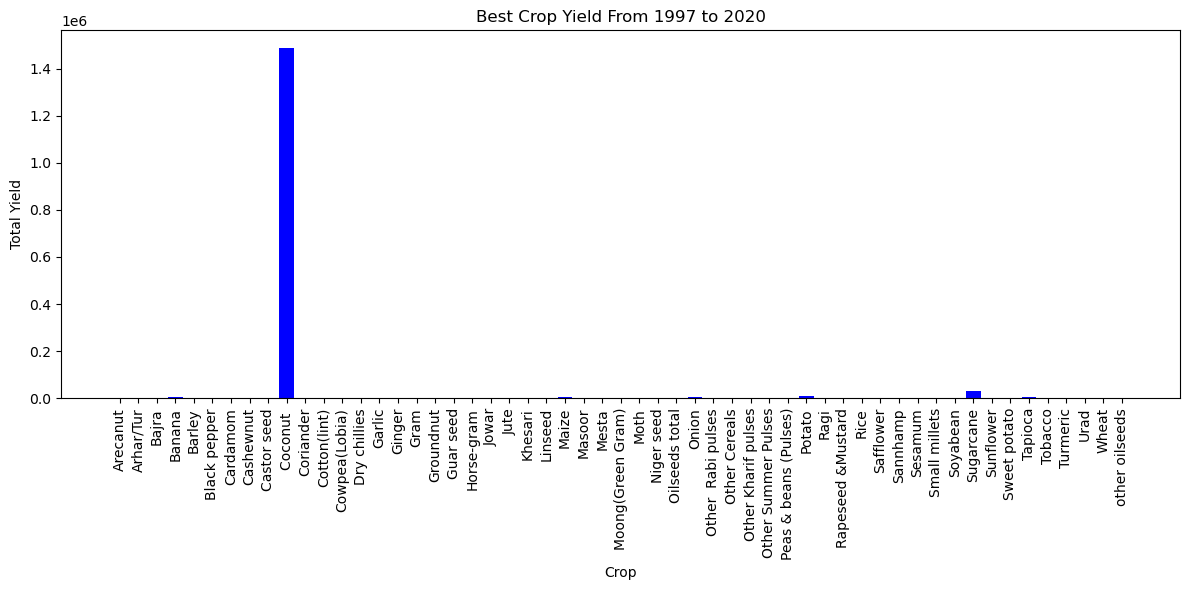

Coconut is the best crop with the highest crop yield from 1997 to 2020


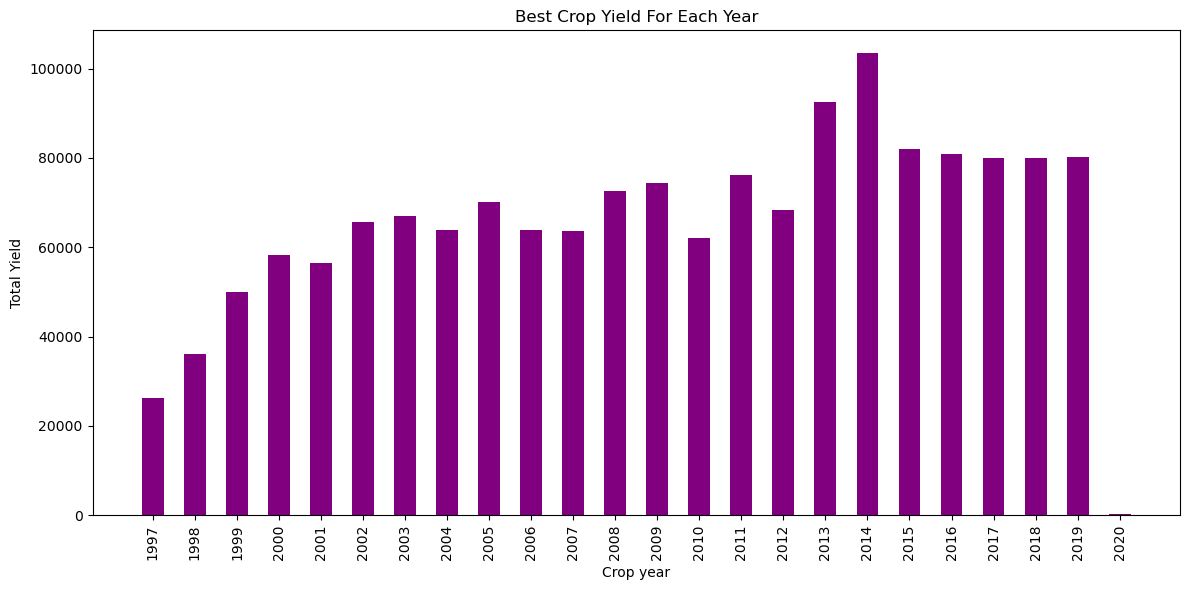

2014 has the highest crop yield: 103400.057623567
2020 has the lowest crop yield: 163.543553181


In [29]:
# Create a bar chart for best crop yield
crop_production = crop_yield_df.groupby("Crop")["Yield"].sum()
best_crop = crop_production[crop_production.values==crop_production.values.max()].keys().str.strip()
plt.figure(figsize=(12, 6))
plt.bar(crop_production.index, crop_production.values, color="blue")
plt.xlabel("Crop")
plt.ylabel("Total Yield")
plt.title("Best Crop Yield From 1997 to 2020")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("output/Best_crop_yield.png")
plt.show()
print(f"{best_crop[0]} is the best crop with the highest crop yield from 1997 to 2020")

# Create a bar chart for best crop yield for each year
production_year = crop_yield_df.groupby("Crop_Year")["Yield"].sum()
highest_yield_year = production_year[production_year.values==production_year.values.max()].keys()
lowest_yield_year  = production_year[production_year.values==production_year.values.min()].keys()
x_axis = np.arange(len(production_year))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(12, 6))
plt.bar(x_axis, production_year, color='purple', align="center", width = 0.52)
plt.xticks(tick_locations, list(production_year.index), rotation=90)
plt.title("Best Crop Yield For Each Year")
plt.xlabel("Crop year")
plt.ylabel("Total Yield")
plt.tight_layout()
plt.savefig("output/Best_crop_yield_year.png")
plt.show()

print(f"{highest_yield_year[0]} has the highest crop yield: {production_year.values.max()}\n{lowest_yield_year[0]} has the lowest crop yield: {production_year.values.min()}")

## Analysing Top 5 Crops for the Kharif Season

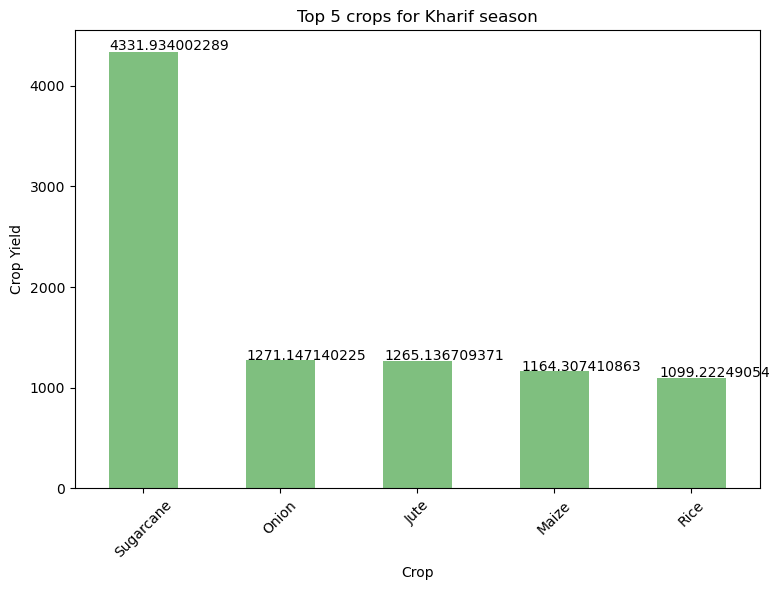

In [30]:
#Top 5 Crop produced for Kharif season
kharif_crop_yield_df = crop_yield_df[crop_yield_df["Season"].str.strip()=="Kharif"]
top_crop_yield_df= kharif_crop_yield_df.groupby("Crop")["Yield"].sum().sort_values(ascending=False)
top5=top_crop_yield_df.head(5)
br= top5.plot(kind="bar", figsize=(8,6),title="Top 5 crops for Kharif season",color='g', alpha=0.5, align="center")
plt.xticks(rotation=45)
plt.ylabel("Crop Yield")

# annotate each bar with the value
for b in br.patches:
    # add the label to the bar  
    br.annotate(str(b.get_height()), (b.get_x() * 1.005, b.get_height() * 1.005))

plt.tight_layout()
plt.savefig("output/kharif_top5_crop_yield.png")
plt.show()

# Analysing Overall Relationship between Annual Rainfall on Crop Production

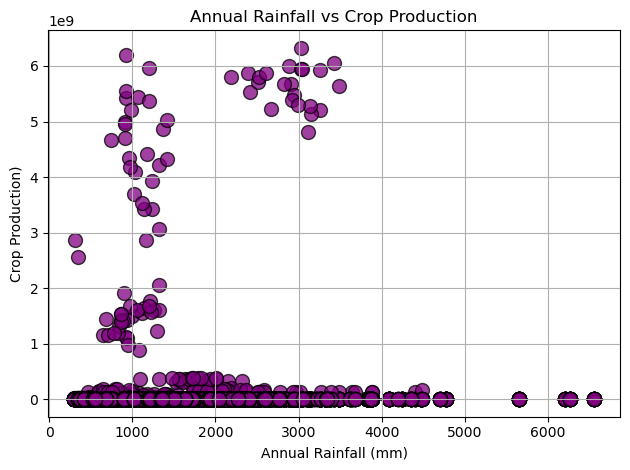

The scatter plot is to represnt the relationship between the Annual Rainfall and Crop production
The Highest crop production: 6326000000 is recorded at 3030.9mm rainfall 


In [31]:
# Generate a scatter plot showing the relationship between annual rainfall on crop production
crop_production = crop_yield_df["Production"]
rainfall = crop_yield_df["Annual_Rainfall"]

# Highest crop yield at annual rainfall
sorted_crop_production = crop_yield_df.sort_values("Production",ascending=False)
max_crop_df =sorted_crop_production.iloc[:1] 
heighest_yield = max_crop_df["Production"].values
rainfall_for_heighest_crop = max_crop_df["Annual_Rainfall"].values


# create a scatter plot
plt.scatter(rainfall, crop_production, marker="o", facecolors="purple", edgecolors="black",
            s=100, alpha=0.75)
plt.grid()
plt.xlabel("Annual Rainfall (mm)")
plt.ylabel("Crop Production)")
plt.title(f"Annual Rainfall vs Crop Production")
plt.tight_layout()
plt.savefig("output/rainfall_crop_yield.png")
plt.show()

print(f"The scatter plot is to represnt the relationship between the Annual Rainfall and Crop production\nThe Highest crop production: {heighest_yield[0]} is recorded at {rainfall_for_heighest_crop[0]}mm rainfall ")

# Pesticides vs. Crop Yield

In [32]:
# Picking out relevant columns
reduced_crop_df = crop_yield_df[['Crop','Crop_Year','Pesticide', 'Yield', 'Production']]

# Displaying created DataFrame
reduced_crop_df.head()

,Crop,Crop_Year,Pesticide,Yield,Production
0,Arecanut,1997,22882.34,0.796087,56708
1,Arhar/Tur,1997,2057.47,0.710435,4685
2,Castor seed,1997,246.76,0.238333,22
3,Coconut,1997,6093.36,5238.051739,126905000
4,Cotton(lint),1997,539.09,0.420909,794


In [33]:
# Define a function to create Linear Regression plots
def linear_regression(x,y):    
    (slope, intercept, rvalue, p_value, stderr) = linregress(x, y)
    print(f"r-value is {rvalue ** 2}")
    ttest_result = ttest_ind(x,y,equal_var=False)
    pvalue = ttest_result.pvalue
    stasticvalue= ttest_result.statistic   
    print("\x1b[32;1mHypothesis testing:\x1b[0m")    
    if pvalue<0.05:
        print("Accepting Null hypothesis and rejecting Alternative hypothesis")
        print(f"pvalue is {pvalue:.4f},test stastics is {stasticvalue:.4f} and correlation is statistically significant.")
    else:
        print("Accepting Alternative hypothesis and rejecting Null hypothesis")
        print(f"pvalue is {pvalue:.4f}, test stastics is {stasticvalue:.4f}  and correlation is statistically insignificant.")
        
    regress_values = x * slope + intercept
    line_eq = "y =" + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x, y)
    plt.plot(x,regress_values,"r-")
    return line_eq

# Define a fuction for annotating
def annotate(line_eq, a, b):
    plt.annotate(line_eq,(a,b),fontsize=15,color="red")

NULL Hypothesis: Low Pesticide usage will increase Crop Yield
ALTERNATE Hypothesis:High Pesticide usage will increase Crop Yield
r-value is 3.1742187184668185e-06
Hypothesis testing:
Accepting Null hypothesis and rejecting Alternative hypothesis
pvalue is 0.0000,test stastics is 32.0835 and correlation is statistically significant.


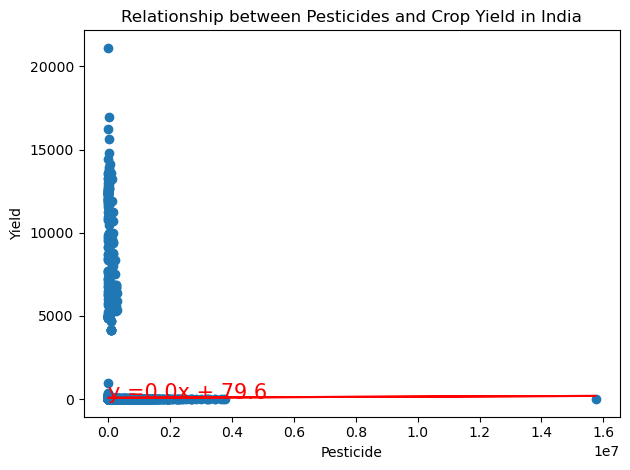

The plot is to represent the Impact of Pesticide on Crop Yield 
The highest Yield is recorded at lowest pesticide usage


In [34]:
#Hypothesis assumptions
print("\x1b[34;1mNULL Hypothesis: Low Pesticide usage will increase Crop Yield\nALTERNATE Hypothesis:High Pesticide usage will increase Crop Yield\x1b[0m")

#Generate a line plot showing relationship between usage of pesticide on crop yield
line_eq = linear_regression(reduced_crop_df['Pesticide'], reduced_crop_df['Yield'])
#Annotate the plot
annotate(line_eq, 20,20)


# Set a title
plt.title("Relationship between Pesticides and Crop Yield in India")

# Set xlabel
plt.xlabel("Pesticide")

# Set ylabel
plt.ylabel("Yield")

plt.tight_layout()

# Save the figure
plt.savefig("output/Pesticides_Crop_Yield.png")

plt.show()


print("The plot is to represent the Impact of Pesticide on Crop Yield \nThe highest Yield is recorded at lowest pesticide usage")

NULL Hypothesis: Low Pesticide usage will increase Crop Production
ALTERNATE Hypothesis:High Pesticide usage will increase Crop Production
r-value is 0.0012370316329160002
Hypothesis testing:
Accepting Null hypothesis and rejecting Alternative hypothesis
pvalue is 0.0000,test stastics is -8.7411 and correlation is statistically significant.


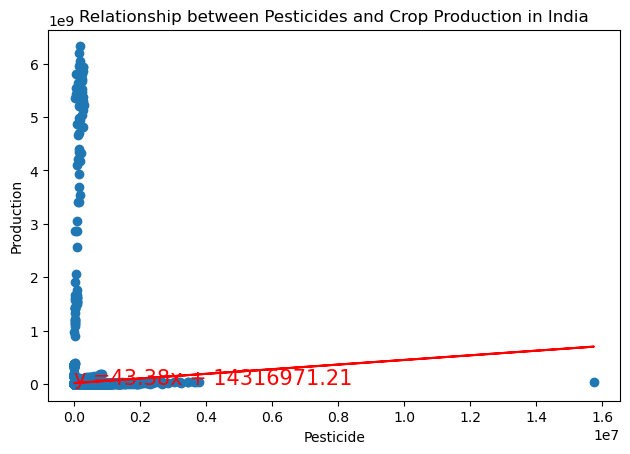

The plot is to represent the Impact of Pesticide on Crop Production 
The highest Crop Production is recorded at lowest Pesticide usage


In [35]:
#Hypothesis assumptions
print("\x1b[34;1mNULL Hypothesis: Low Pesticide usage will increase Crop Production\nALTERNATE Hypothesis:High Pesticide usage will increase Crop Production\x1b[0m")

#Generate a line plot showing relationship between usage of pesticide on crop Production
line_eq = linear_regression(reduced_crop_df['Pesticide'], reduced_crop_df['Production'])
#Annotate the plot
annotate(line_eq, 20,20)

# Set a title
plt.title("Relationship between Pesticides and Crop Production in India")

# Set xlabel
plt.xlabel("Pesticide")

# Set ylabel
plt.ylabel("Production")

plt.tight_layout()
# Save the figure
plt.savefig("output/Pesticides_Crop_Production.png")

plt.show()


print("The plot is to represent the Impact of Pesticide on Crop Production \nThe highest Crop Production is recorded at lowest Pesticide usage")

# Analysing Annual Rainfall & Crop Production Across for Kharif Season Across Each State in India Using .csv Files For Coordinates

In [36]:
crop_yield_df = crop_yield_df[crop_yield_df["Season"].str.strip()=="Kharif"]
crop_yield_df.head()

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909
7,Jute,1997,Kharif,Assam,94520.0,904095,2051.4,8995468.40,29301.20,9.919565
9,Maize,1997,Kharif,Assam,19216.0,14721,2051.4,1828786.72,5956.96,0.615652


In [37]:
# Geoviews to show the rainfall across the states of india
warnings.filterwarnings('ignore')

# States data file
states_data_path = "resources/states.csv"

# Read the mouse data and the study results
states_df = pd.read_csv(states_data_path)

# Combine the data into a single DataFrame
merged_df= pd.merge(crop_yield_df,states_df,on="State")

# Display the data table for preview
merged_df.head() 

# new columns to the dataframe
states_df["Annual Rainfall"] = ""
states_df["Crop Production"] = ""
states_df["Season"] = ""
#aggregate rainfall and crop production column values
Annual_Rainfall =  merged_df.groupby(['State'])['Annual_Rainfall'].sum()
crop_production =  merged_df.groupby(['State'])['Production'].sum()
Season =  merged_df.groupby(['State'])['Season'].unique()

#populate rainfall and crop production column values
states_df["Annual Rainfall"] = Annual_Rainfall.values
states_df["Crop Production"] = crop_production.values
states_df["Season"] = Season.values

# Display the data table for preview
states_df.head()

,State,Lat,Lng,Annual Rainfall,Crop Production,Season
0,Andhra Pradesh,14.750429,78.570026,521818.500000,340830752,[Kharif ]
1,Arunachal Pradesh,27.100399,93.616601,304592.700000,5861787,[Kharif ]
2,Assam,26.749981,94.216667,429814.372724,19107777,[Kharif ]
3,Bihar,25.785414,87.479973,404223.900000,39117615,[Kharif ]
4,Chhattisgarh,21.295132,81.828232,494404.300000,127211880,[Kharif ]


In [38]:
plot_map_1= states_df.hvplot.points("Lng","Lat",geo=True,tiles="OSM",frame_width=700,frame_height=500,
                                    scale = 0.01, color = "State",hover_cols=["State","Season","Annual Rainfall","Crop Production"])


# Display the map plot
plot_map_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (State,Season,Annual Rainfall,Crop Production)

# Analysing Annual Rainfall & Crop Production  For Kharif Season Across Each State in India Using Weather API for Coordinates

In [39]:
# Geoviews to show the rainfall across the states of india
warnings.filterwarnings('ignore')

# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
country = ",IN"
units = "metric"
success =200
Telangana_state="Telangana"
Tel_df = states_df[states_df["State"]==Telangana_state]
Tel_lat=Tel_df["Lat"].values
Tel_lng=Tel_df["Lng"].values


# Build partial query URL
query_url = f"{url}appid={api_key}&units={units}&q="


# States data file
states = crop_yield_df["State"].unique()

# set up lists to hold reponse info
lat = []
lng = []

# Loop through the list of cities and perform a request for data on each
for state in states:
    res = requests.get(query_url + state + country)    
    if res.status_code == success:
        response = res.json()        
        lat.append(response['coord']['lat'])
        lng.append(response['coord']['lon'])
    elif state == Telangana_state:
        lat.append(Tel_lat)
        lng.append(Tel_lng)

        
        
states_dict = {
    "State": states,
    "lat": lat,
    "lng": lng
}

states1_df = pd.DataFrame(states_dict)      


# Combine the data into a single DataFrame
merged_df= pd.merge(crop_yield_df,states1_df,on="State")

# Display the data table for preview
merged_df.head() 

# new columns to the dataframe
states1_df["Annual Rainfall"] = ""
states1_df["Crop Production"] = ""
states1_df["Season"] = ""
#aggregate rainfall and crop production column values
Annual_Rainfall =  merged_df.groupby(['State'])['Annual_Rainfall'].sum()
crop_production =  merged_df.groupby(['State'])['Production'].sum()
Season =  merged_df.groupby(['State'])['Season'].unique()


#populate rainfall and crop production column values
states1_df["Annual Rainfall"] = Annual_Rainfall.values
states1_df["Crop Production"] = crop_production.values
states1_df["Season"] = Season.values



# Display the data table for preview
states1_df.head()

,State,lat,lng,Annual Rainfall,Crop Production,Season
0,Assam,26,93,521818.500000,340830752,[Kharif ]
1,Karnataka,13.5,76,304592.700000,5861787,[Kharif ]
2,Meghalaya,25.5,91.3333,429814.372724,19107777,[Kharif ]
3,West Bengal,24,88,404223.900000,39117615,[Kharif ]
4,Puducherry,11.9333,79.8167,494404.300000,127211880,[Kharif ]


In [40]:
plot_map_2= states1_df.hvplot.points("lng","lat",geo=True,tiles="OSM",frame_width=700,frame_height=500,
                                    scale = 0.01, color = "State",hover_cols=["State","Season","Annual Rainfall","Crop Production"])


# Display the map plot
plot_map_2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (State,Season,Annual Rainfall,Crop Production)

## Duc

# Geography vs. Crop Yield

In [41]:
#Set file path
crop_csv=Path("resources/crop_yield.csv")
crop_csv

#Gather data from csv file
crop_df=pd.read_csv(crop_csv)

#CLean data
crop_cleaned_df=crop_df[["Crop","Crop_Year","State","Area","Fertilizer","Pesticide","Yield"]]

In [42]:
# Function for ploting scatter plot
def plotting_scatter_plot(x,y,
                          x_label,y_label,title,
                         edgecolors='black',c="b"):
    # Build scatter plot
    plt.scatter(x,y,edgecolors=edgecolors,c=c)
    # Incorporate the other graph properties
    plt.grid()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

# Define a function for ploting Linear Regression Plot
def linear_reg_plot(x_values,y_values,annotation_percentage_x=0.4,annotation_percentage_y=0.1,
                    line_color="r-",annotation_color="red",annotation_fontsize=15,annotation_show=True):
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    
    regress_values = x_values * slope + intercept
    
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    
        
    plt.scatter(x_values,y_values)
    
    plt.plot(x_values,regress_values,line_color)
    
    # Calculate best-fit coordinates
    
    # Adjust the position of anotation x-coordinate
    best_fit_x = max(x_values) - annotation_percentage_x * (max(x_values) - min(x_values))
    # Adjust the position of anotation y-coordinate
    best_fit_y = max(y_values) - annotation_percentage_y * (max(y_values) - min(y_values))  
    if annotation_show==True:
        plt.annotate(line_eq,(best_fit_x,best_fit_y),fontsize=annotation_fontsize,color=annotation_color)
        print(f"The r-value is: {rvalue} \nThe p-value is: {pvalue}")

#The above functions was copied from Duc Trieu's previous assigment (Py weather)

In [43]:
# Set the API base URL
url = "http://api.openweathermap.org/data/2.5/weather?"

# Define an empty list to fetch the weather data for each city
states_name=crop_cleaned_df["State"].unique()
error_found=[]
state_data = []

# Print to logger
print("Starting to locate...")
print("-----------------------------")

appid=weather_api_key
#Loop through all state to retrieve data
for state in states_name:
    print("Getting the longitude and latitude of %s." % (state))
    params={"q": state + ",IN",
           "appid":appid}
    try:
        response=requests.get(url,params=params).json()
        state_lat=response["coord"]["lat"]
        state_lon=response["coord"]["lon"]
        print("The coordinates of %s: Latitude: %s | Longitude: %s." % (state,state_lat,state_lon))
        state_data.append({"State":state,
                          "Lat":state_lat,
                          "Lon":state_lon})
        print("*****")
    except Exception as e:
        print("Uh oh, something went wrong. Error code: %s" % (e))
        error_found.append(state)
        print("*****")
print("------------------------------")
print("Finish recording coordinates. Data has been updated! \n %s error(s) found: (%s)." % (len(error_found),error_found))
print("------------------------------")

Starting to locate...
-----------------------------
Getting the longitude and latitude of Assam.
The coordinates of Assam: Latitude: 26 | Longitude: 93.
*****
Getting the longitude and latitude of Karnataka.
The coordinates of Karnataka: Latitude: 13.5 | Longitude: 76.
*****
Getting the longitude and latitude of Kerala.
The coordinates of Kerala: Latitude: 10 | Longitude: 76.5.
*****
Getting the longitude and latitude of Meghalaya.
The coordinates of Meghalaya: Latitude: 25.5 | Longitude: 91.3333.
*****
Getting the longitude and latitude of West Bengal.
The coordinates of West Bengal: Latitude: 24 | Longitude: 88.
*****
Getting the longitude and latitude of Puducherry.
The coordinates of Puducherry: Latitude: 11.9333 | Longitude: 79.8167.
*****
Getting the longitude and latitude of Goa.
The coordinates of Goa: Latitude: 15.3333 | Longitude: 74.0833.
*****
Getting the longitude and latitude of Andhra Pradesh.
The coordinates of Andhra Pradesh: Latitude: 16 | Longitude: 79.
*****
Getting

In [44]:
#As the coordinates for Telangana was not found, it will be added manually
state_data.append({"State":"Telangana",
                          "Lat":18.1124,
                          "Lon":79.0193})

In [45]:
#Convert state coordinates into df
state_coor_df=pd.DataFrame(state_data)
#Get average yield for each state by Year
average_yield_states=crop_cleaned_df.groupby(["State"])["Yield"].mean().reset_index()

#merge state_coor and yield by state
yield_states=pd.merge(crop_cleaned_df[["State","Yield"]],state_coor_df,on="State",how="inner")

#merge state_coor and average yield by state
merged_average_yield_state=pd.merge(average_yield_states,state_coor_df,on="State",how="inner")

The r-value is: -0.07984619433116448 
The p-value is: 3.215222215838964e-29


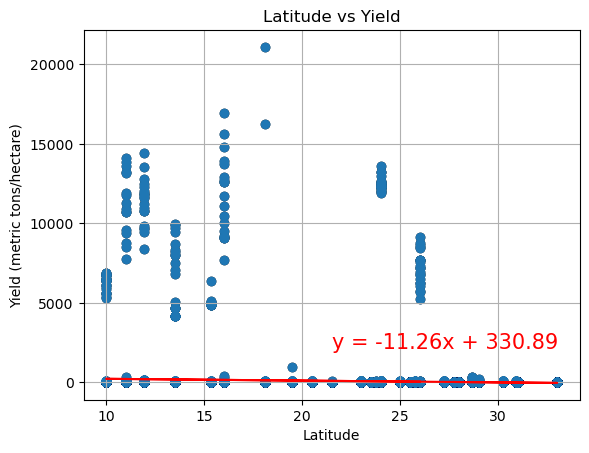

In [46]:
#Plotting scatter plot to show the relationship of Latitude and Yield
plotting_scatter_plot(yield_states["Lat"],yield_states["Yield"],"Latitude","Yield (metric tons/hectare)","Latitude vs Yield")
#Plot linear correlation line
linear_reg_plot(yield_states["Lat"],yield_states["Yield"],annotation_percentage_x=0.5,annotation_percentage_y=0.9)
plt.savefig("output/yield_by_state/Latitude vs Yield.png")

**Comments:**
- There is a weak relationship between the latitude and the yield.
- The relationship is statistically significant.
- There are some omissions such as: type of crop, year

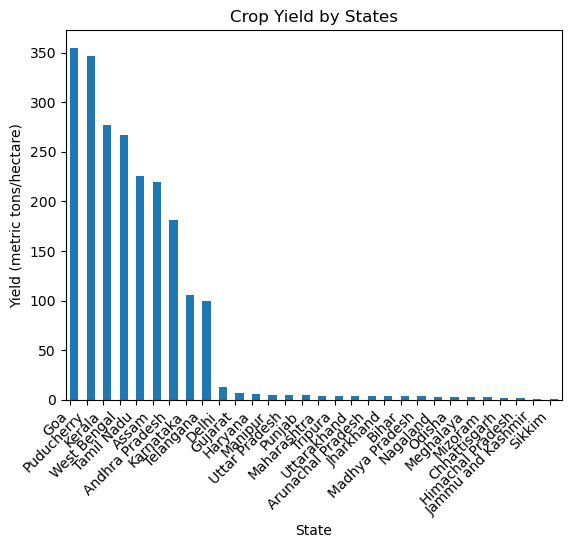

In [47]:
#Plotting bar chart to see the different between states

plot_bar_average_yield_states=average_yield_states.sort_values(by="Yield",ascending=False).plot(kind="bar",
                                                                                                x="State",
                                                                                                align='edge', 
                                                                                                width=0.5,legend=False)
plt.title("Crop Yield by States")
plt.ylabel("Yield (metric tons/hectare)")
plt.xticks(rotation=45, ha='right')
plt.savefig("output/yield_by_state/Crop Yield by States.png")
plt.show()

**Comments:**
- 9 states show high yield when compared to the majority of the states listed in the graph, which have relatively very low yield.
- Some investigations are needed for the states of Goa, Puducherry, Kerala, West Bengal, Tamil Nadu, Assam, Andhra Pradesh, Karnataka and Telangana to find out the reasons why these states display high crop yield. This could be due to the properties of the crops, the quality of soil, etc.

In [48]:
#Showing Average Yield by state on map
map_yield_stats=merged_average_yield_state.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    size = "Yield",
    scale = 1,
    color = "State",
    alpha=0.8)
map_yield_stats.opts(xlabel="Longitude",ylabel="Latitude")
#show map
map_yield_stats

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (State,Yield)

# Fertiliser vs. Crop Yield (Duc)

In [49]:
#Calculate how much fertilizer used per hectares
crop_df["Fertilizer per hectares"]=crop_df["Fertilizer"]/crop_df["Area"]

The r-value is: 0.0018437987210733573 
The p-value is: 0.7958659356671683


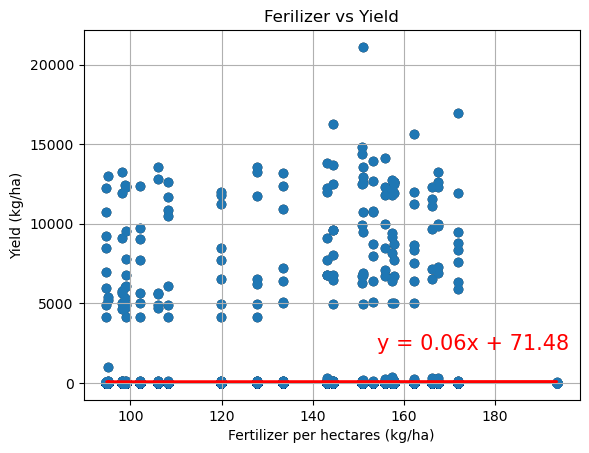

In [50]:
# Plotting the correlation between Fertilizer used and Yield
plotting_scatter_plot(crop_df["Fertilizer per hectares"],crop_df["Yield"],
                      x_label="Fertilizer per hectares (kg/ha)",y_label="Yield (kg/ha)",
                     title="Ferilizer vs Yield")
linear_reg_plot(crop_df["Fertilizer per hectares"],crop_df["Yield"],annotation_percentage_y=0.9)
plt.savefig("output/yield_by_state/Ferilizer vs Yield.png")

**Comments:**
- There is no statistically significant relationship between the use of fertiliser and yield.

In [51]:
#Yield by year df
yield_years=crop_df.groupby("Crop_Year")["Yield"].mean()
#Fertilizer used per hectare by year df
fertilizer_years=crop_df.groupby("Crop_Year")["Fertilizer per hectares"].mean()
#Merge Fertilizer and Yield
merged_yield_ferilizer_years=pd.merge(fertilizer_years,yield_years,on="Crop_Year",how="inner")

The r-value is: 0.9241759680119975 
The p-value is: 1.1523017946289214e-10


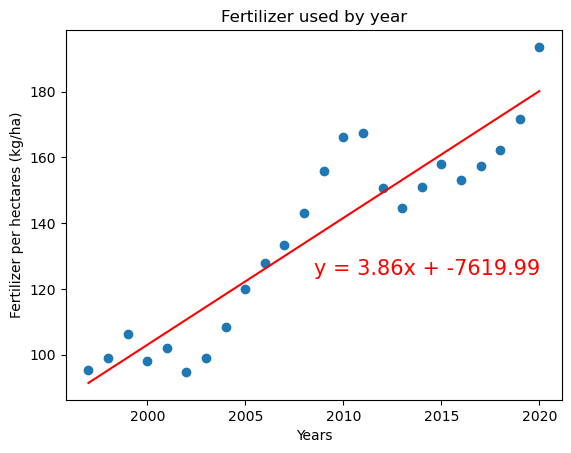

In [52]:
# Plotting line to show the relationship of Fertilizer by Year

linear_reg_plot(merged_yield_ferilizer_years.index.values,
                merged_yield_ferilizer_years["Fertilizer per hectares"],annotation_percentage_x=0.5,annotation_percentage_y=0.7)
plt.xlabel("Years")
plt.ylabel("Fertilizer per hectares (kg/ha)")
plt.title("Fertilizer used by year")

plt.savefig("output/yield_by_state/Fertilizer used by year.png")

**Comments:**
- A strong correlation was found between Fertilizer used and Year.
- This show a significant increase in fertilizer used in India.

The r-value is: -0.10812560842099424 
The p-value is: 0.6150302498836117


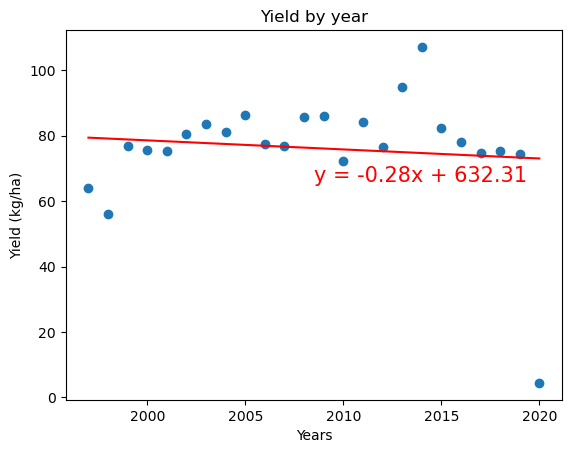

In [53]:
# Plotting line to show the relationship of Yield by Year
linear_reg_plot(merged_yield_ferilizer_years.index.values,
                merged_yield_ferilizer_years["Yield"],annotation_percentage_x=0.5,annotation_percentage_y=0.4)
plt.xlabel("Years")
plt.ylabel("Yield (kg/ha)")
plt.title("Yield by year")

plt.savefig("output/yield_by_state/Yield by year.png")

**Comments:**
- There is no statistically significant relationship between time and yield.